In [1]:
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

# Path for .pkl files
target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\mixture_shocktube\\"
# Path for Quail source code
source_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\"

In [2]:
# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

os.chdir(target_dir)

In [ ]:
%%capture
%run "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\quail" "conduit.py"
# Run box to run

In [314]:
# Waves first arrive at left boundary of [-600,600] at ~ output20 (400ms)
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_21.pkl")
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_35.pkl")
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit2_35.pkl")
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_35.pkl")
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_52.pkl")
solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_163.pkl")
#
#  for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.semilogy(solver.state_coeffs[:,:,i])

if solver.physics.NDIMS == 1:
	pltqtys = ["pDensityA", "pDensityWv", "pDensityM", "XMomentum",
		"Energy", "pDensityWt", "Pressure", "SoundSpeed", "Temperature",
		"XVelocity", "volFracM", "pDensityC"]
	equal_aspect_ratio = False
else:
	pltqtys = ["pDensityA", "XMomentum", "YMomentum", "Pressure", "Temperature"]
	equal_aspect_ratio = True

for pltqty in pltqtys:
	plot.plot_solution(solver.mesh, solver.physics, solver, pltqty,
				plot_numerical=True, plot_exact=False, plot_IC=False,
				create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
				equidistant_pts=False, include_mesh=False, regular_2D=False,
				equal_AR=equal_aspect_ratio)

In [316]:
idx = 163
# solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_{idx}.pkl")
# plot.plot_solution(solver.mesh, solver.physics, solver, "Pressure",
# 				plot_numerical=True, plot_exact=False, plot_IC=False,
# 				create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
# 				equidistant_pts=False, include_mesh=False, regular_2D=False,
# 				equal_AR=equal_aspect_ratio)
solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm2_{idx}.pkl")
plot.plot_solution(solver.mesh, solver.physics, solver, "Pressure",
				plot_numerical=True, plot_exact=False, plot_IC=False,
				create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
				equidistant_pts=False, include_mesh=False, regular_2D=False,
				equal_AR=equal_aspect_ratio)

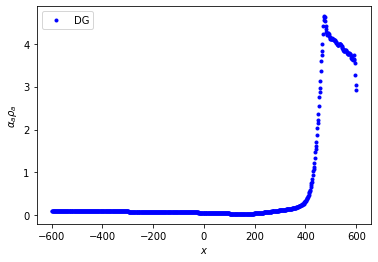

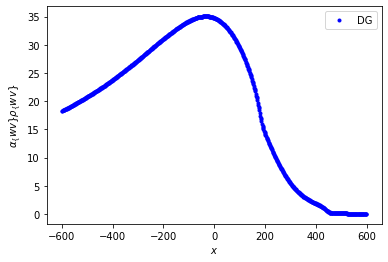

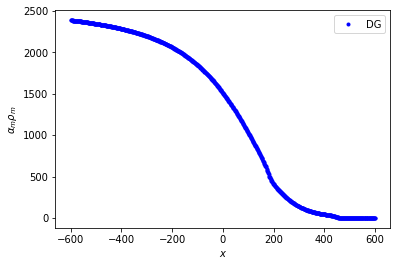

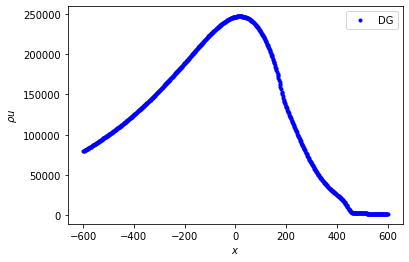

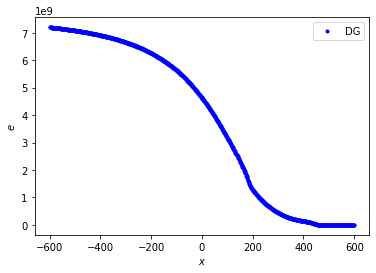

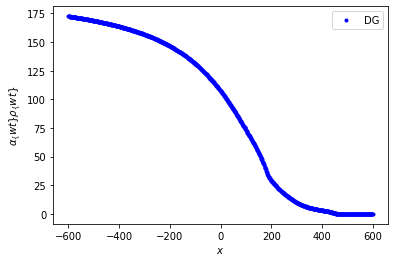

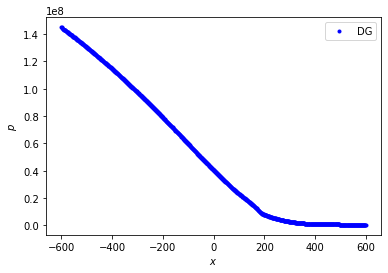

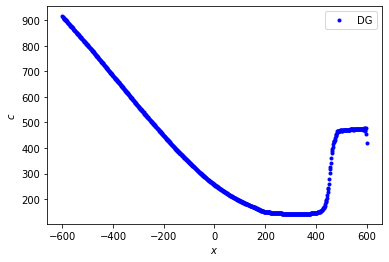

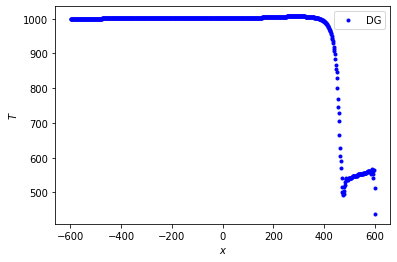

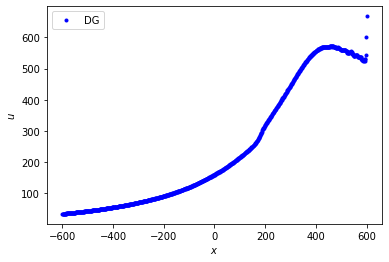

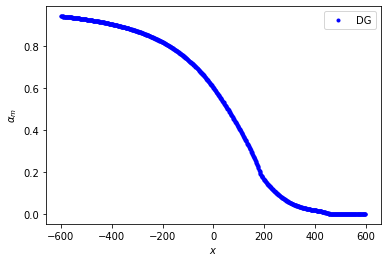

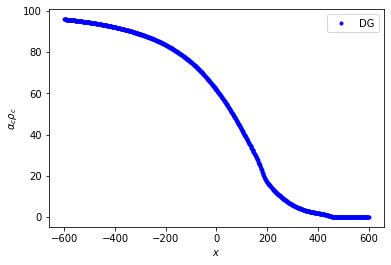

In [16]:
solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_164.pkl")

if solver.physics.NDIMS == 1:
	pltqtys = ["pDensityA", "pDensityWv", "pDensityM", "XMomentum",
		"Energy", "pDensityWt", "Pressure", "SoundSpeed", "Temperature",
		"XVelocity", "volFracM", "pDensityC"]
	equal_aspect_ratio = False
else:
	pltqtys = ["pDensityA", "XMomentum", "YMomentum", "Pressure", "Temperature"]
	equal_aspect_ratio = True

for pltqty in pltqtys:
	plot.plot_solution(solver.mesh, solver.physics, solver, pltqty,
				plot_numerical=True, plot_exact=False, plot_IC=False,
				create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
				equidistant_pts=False, include_mesh=False, regular_2D=False,
				equal_AR=equal_aspect_ratio)

In [ ]:
# Minimum of crystal partial density
np.min(solver.state_coeffs[:,:,6])

solver.state_coeffs[:,:,4]

In [304]:
snapshotidx = 163
snapshotidx = 163

solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_{snapshotidx}.pkl")
x_conduit = solver.mesh.node_coords
p_conduit = solver.physics.compute_additional_variable("Pressure", solver.state_coeffs, False)

solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_{snapshotidx}.pkl")

p = solver.physics.compute_additional_variable("Pressure", solver.state_coeffs, False)
mesh = solver.mesh
# plt.plot(p.ravel())
# plt.scatter(mesh.node_coords[:,0], mesh.node_coords[:,:,1], p)
mesh.node_coords.shape
x = plot.get_sample_points(
			mesh, solver, solver.physics, solver.basis, True)
plt.scatter(x.mean(axis=1)[:,0], x.mean(axis=1)[:,1],
  c=p.mean(axis=1)[:,0])
# x.mean(axis=1).shape
# p.mean(axis=1)[:,0].shape
plt.axis("equal")

plt.figure()
# plt.plot(x.mean(axis=1)[:,1], p.mean(axis=1)[:,0], '.')
plt.plot(x.mean(axis=1)[:,1]+150.0, p[:,:,0], '.')
# p[:,:,0].shape

# Plot conduit
xnodes_conduit = np.zeros_like(p_conduit)
xnodes_conduit[:,0,:] = x_conduit[:-1]
xnodes_conduit[:,2,:] = x_conduit[1:]
xnodes_conduit[:,1,:] = 0.5*xnodes_conduit.sum(axis=1)
# plt.figure()
plt.plot(xnodes_conduit.ravel()-600, p_conduit.ravel() ,'.-')
plt.xlim([-100,100])
plt.ylim([5e4,300000])

(50000.0, 300000.0)

In [305]:
snapshotidx = 82
solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_{snapshotidx}.pkl")
num_saves = 82# 96
size_tuple = list(solver.state_coeffs[:,:,0:1].shape)
size_tuple.append(num_saves+1)
p_hist = np.zeros(tuple(size_tuple))
save_count = range(num_saves+1)
# x for 2D domain
x = plot.get_sample_points(
			solver.mesh, solver, solver.physics, solver.basis, True)

solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_{snapshotidx}.pkl")
size_tuple = list(solver.state_coeffs[:,:,0:1].shape)
size_tuple.append(num_saves+1)
x_conduit = plot.get_sample_points(
			solver.mesh, solver, solver.physics, solver.basis, True)
p_conduit_hist = np.zeros(tuple(size_tuple))


key_quant = "Pressure"
for i in save_count:
  solver = readwritedatafiles.read_data_file(f"mixture_shocktube_conduit_{i}.pkl")
  p_conduit_hist[:,:,:,i] = solver.physics.compute_additional_variable(key_quant, solver.state_coeffs, False)
  # p_conduit_hist[:,:,:,i] = solver.state_coeffs[:,:,2:3]
  solver = readwritedatafiles.read_data_file(f"mixture_shocktube_atm1_{i}.pkl")
  p_hist[:,:,:,i] = solver.physics.compute_additional_variable(key_quant, solver.state_coeffs, False)
  # p_hist[:,:,:,i] = solver.state_coeffs[:,:,2:3]
  # Approximate energy
  # E_2D = np.sum(solver.state_coeffs[:,:,5])
  


# Problematic location
# plot.plot_solution(solver.mesh, solver.physics, solver, "Pressure",
# 				plot_numerical=True, plot_exact=False, plot_IC=False,
# 				create_new_figure=True, ylabel=None, fmt='b.', legend_label="DG",
# 				equidistant_pts=False, include_mesh=False, regular_2D=False,
# 				equal_AR=equal_aspect_ratio)
# plt.ylim([-150, -100])
# plt.xlim([0,50])
# plt.clim([-30000,60000*0])

# plt.figure()
# plt.plot(x.mean(axis=1)[:,1], p.mean(axis=1)[:,0], '.')
# plt.plot(x.mean(axis=1)[:,1]+150.0, p[:,:,0], '.')
# p[:,:,0].shape

In [311]:
import matplotlib.pyplot as plt
%matplotlib tk
# p = solver.physics.compute_additional_variable("Pressure", solver.state_coeffs, False)
# p [258,:,:]
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

from matplotlib import cm

pseudo_x = x.mean(axis=1)[:,1]+150.0
ordering = np.argsort(pseudo_x)
X, Y = np.meshgrid(pseudo_x[ordering], save_count)
Z = p_hist[ordering,0,0,:].squeeze().T

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# p_hist[:,:,-1]
# plt.xlabel("x")

ordering = np.argsort(pseudo_x)

plt.figure()
for i in (save_count):
  plt.plot(pseudo_x[ordering], p_hist[ordering,0,0,i], '.-')
  # plt.hold(True)

In [312]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

x_conduit.mean(axis=1).shape
pseudo_x_conduit = x_conduit.mean(axis=1)[:,0]-200
p_conduit_hist.mean(axis=1)[:,0,:]

ordering = np.argsort(pseudo_x_conduit)
X, Y = np.meshgrid(pseudo_x_conduit[ordering], save_count)
Z = p_conduit_hist.mean(axis=1)[ordering,0,:].squeeze().T

# # Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)



In [313]:
x_global = np.append(pseudo_x, pseudo_x_conduit)
p_global = np.append(p_hist.squeeze(), p_conduit_hist.mean(axis=1)[:,0,:], axis=0)
# p_hist.squeeze().shape
# p_conduit_hist.mean(axis=1)[:,0,:].shape

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# x_global.mean(axis=1).shape

ordering = np.argsort(x_global)
X, Y = np.meshgrid(x_global[ordering], save_count)
Z = p_global[ordering,:].squeeze().T

# # Plot the surface.
surf = ax.plot_surface(X, Y, np.log10(Z), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)




ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [309]:
assert(solver.physics.NDIMS == 2)
# np.argmin(p_hist[117,:,:])
p_hist[117,:,:,-1]
solver.state_coeffs[117,:,:]
# solver.physics.compute_additional_variable("Temperature", solver.state_coeffs, False)[258,:,:]

array([[ 3.209398680959025e+00,  6.665724146209232e-03,
         5.063518253989974e-02, -1.503678678149904e+01,
         1.361393929060994e+03,  1.428354681030915e+06,
         6.758441915463285e-03,  1.114944583298404e-04],
       [ 3.134122599140428e+00,  6.067382510697860e-03,
         2.029471026448680e-02, -1.854653209297979e+01,
         1.289081507291180e+03,  1.357347295645863e+06,
         6.013511292798749e-03, -5.584483382028718e-05],
       [ 3.027824059362930e+00,  1.029340383516750e-02,
         1.064434449730101e-02, -4.253785638997715e+00,
         1.235182497899851e+03,  1.294823621609165e+06,
         1.038956318848223e-02,  3.884263585032394e-05],
       [ 3.173723178153758e+00,  7.126932485094122e-03,
         6.907999843303714e-02, -1.622033319226930e+00,
         1.362400086291884e+03,  1.420015685576017e+06,
         7.254665140173486e-03,  1.436168986298273e-04],
       [ 3.136071658097668e+00,  6.320915136429413e-03,
         2.062913596830194e-02,  1.471428306